# RMSD/RMSF calculation for BMB hexamer tile from simulations

related to the following paper:

#### Polymorphic in vitro assembly of a bacterial microcompartment shell protein
*Timothy K. Chiang, Alexander Jussupow, Antonino Caliò, Megan C. Gruenberg Cross, Wilson Tao, Kyleigh L. Range,
Arinita Pramanik, Aimee Chi Soe, Kristin N. Parent, Greg L. Hura, Paul D. Ashby, Michael Feig, Markus Sutter, Cheryl
A. Kerfeld*

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
  https://colab.research.google.com/github/feiglab/bmc/blob/main/notebooks/H_H_RMSD_RMSF.ipynb
)

In [1]:
import sys, os
from pathlib import Path

if "google.colab" in sys.modules:
    repo_dir = Path("/content/bmc")
    if not repo_dir.exists():
        !git clone https://github.com/feiglab/bmc.git /content/bmc
    %pip install -r "requirements.txt"
    %cd /content/bmc
    
root = Path.cwd()
if not (root / "src").exists():
    root = root.parent

In [2]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

In [3]:
datadir=str(root)+"/data/H_H/edge_edge"

In [4]:
# exclude flexible termini and missing residues in experimental structure from analysis
resmin=2
resmax=88

In [5]:
t0=md.load(datadir+"/0mM/CA.xtc",top=datadir+"/0mM/CA.pdb")
t100=md.load(datadir+"/100mM/CA.xtc",top=datadir+"/100mM/CA.pdb")
t500=md.load(datadir+"/500mM/CA.xtc",top=datadir+"/500mM/CA.pdb")

In [6]:
traj_sel_str=(f"(resSeq {resmin} to {resmax}) and (chainid 0 to 5)")
atom_indices=t0.topology.select(traj_sel_str)

### RMSD calculation

In [7]:
ref=md.load(datadir+"/5djb.ref.pdb")
ref_atom_indices=ref.topology.select(traj_sel_str)

In [8]:
rmsd0=md.rmsd(t0,ref,atom_indices=atom_indices,ref_atom_indices=ref_atom_indices)
rmsd100=md.rmsd(t100,ref,atom_indices=atom_indices,ref_atom_indices=ref_atom_indices)
rmsd500=md.rmsd(t500,ref,atom_indices=atom_indices,ref_atom_indices=ref_atom_indices)

print(f"Average RMSD 0 mM: {np.mean(rmsd0):.3f} nm")
print(f"Average RMSD 100 mM: {np.mean(rmsd100):.3f} nm")
print(f"Average RMSD 500 mM: {np.mean(rmsd500):.3f} nm")

Average RMSD 0 mM: 0.226 nm
Average RMSD 100 mM: 0.226 nm
Average RMSD 500 mM: 0.218 nm


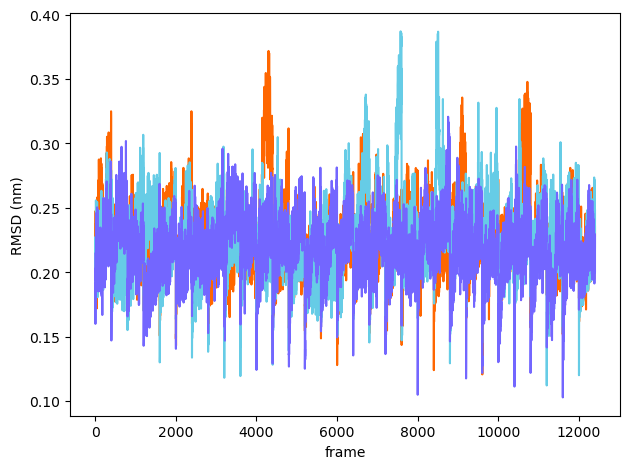

In [9]:
plt.plot(rmsd0, color=(1.0,0.4,0.0))
plt.plot(rmsd100, color=(0.4,0.8,0.9))
plt.plot(rmsd500, color=(0.45,0.4,1.0))
plt.xlabel('frame')
plt.ylabel('RMSD (nm)')
plt.tight_layout()
plt.show()

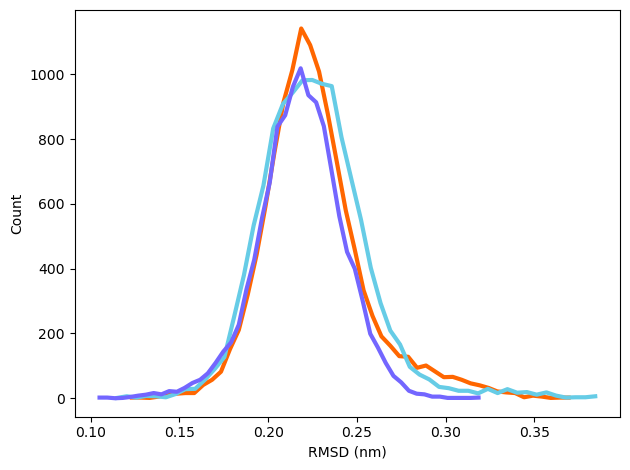

In [10]:
counts0, bin_edges0 = np.histogram(rmsd0, bins=50)
counts100, bin_edges100 = np.histogram(rmsd100, bins=50)
counts500, bin_edges500 = np.histogram(rmsd500, bins=50)

bin_centers0 = 0.5*(bin_edges0[:-1]+bin_edges0[1:])
bin_centers100 = 0.5*(bin_edges100[:-1]+bin_edges100[1:])
bin_centers500 = 0.5*(bin_edges500[:-1]+bin_edges500[1:])

plt.plot(bin_centers0, counts0, color=(1.0,0.4,0.0),linewidth=3)  
plt.plot(bin_centers100, counts100, color=(0.4,0.8,0.9),linewidth=3)  
plt.plot(bin_centers500, counts500, color=(0.45,0.4,1.0),linewidth=3)  

plt.xlabel("RMSD (nm)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### RMSF calculation

In [11]:
def rmsf(traj,resmin,resmax):   
    top = traj.topology
    all_list=top.select(f"(resSeq {resmin} to {resmax}) and (chainid 0 to 5)")
    aligned=traj[:]
    aligned=aligned.superpose(aligned, frame=0, atom_indices=all_list, ref_atom_indices=all_list)
    mean_xyz=aligned.xyz.mean(axis=0,keepdims=True)
    refavg=md.Trajectory(mean_xyz,top)
    chains=range(6)
    rmsf_all=[]
    for cid in chains:
        chain_list = top.select(f"chainid {cid} and resSeq {resmin} to {resmax}")
        coords = aligned.xyz[:, chain_list, :]
        disp = coords - mean_xyz[:, chain_list, :]   # (n_frames, n_sel_atoms, 3)
        sq_disp = np.sum(disp**2, axis=2)        # (n_frames, n_sel_atoms)
        rmsf_chain = np.sqrt(sq_disp.mean(axis=0))   # (n_sel_atoms,)
        rmsf_all.append(rmsf_chain)
 
    rmsf_all = np.array(rmsf_all)  # (6, n_sel_res)
    rmsf_mean = rmsf_all.mean(axis=0)
    rmsf_sem  = rmsf_all.std(axis=0, ddof=1) / np.sqrt(rmsf_all.shape[0])
    atom_indices_chain0 = top.select(f"chainid 0 and resSeq {resmin} to {resmax}")
    res_labels = [top.atom(i).residue.resSeq for i in atom_indices_chain0]
    return rmsf_mean, rmsf_sem, res_labels

In [12]:
rmsf0,sem0,res0=rmsf(t0,resmin,resmax)
rmsf100,sem100,res100=rmsf(t100,resmin,resmax)
rmsf500,sem500,res500=rmsf(t500,resmin,resmax)

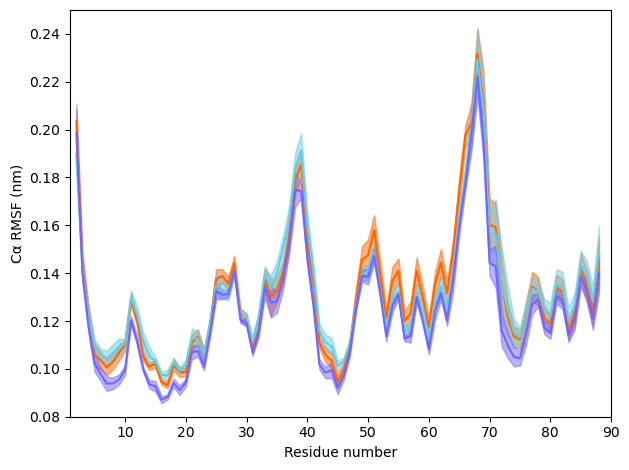

In [13]:
plt.figure()
plt.plot(res0, rmsf0, color=(1.0, 0.4, 0.0))
plt.fill_between(res0,rmsf0-sem0,rmsf0+sem0,color=(1.0, 0.4, 0.0),alpha=0.5)

plt.plot(res100, rmsf100, color=(0.4, 0.8, 0.9))
plt.fill_between(res100,rmsf100-sem100,rmsf100+sem100,color=(0.4, 0.8, 0.9),alpha=0.5)

plt.plot(res500, rmsf500, color=(0.45, 0.4, 1.0))
plt.fill_between(res500,rmsf500-sem500,rmsf500+sem500,color=(0.45, 0.4, 1.0),alpha=0.5)
plt.xlim([1,90])
plt.ylim([0.08, 0.25])
plt.xlabel("Residue number")
plt.ylabel("Cα RMSF (nm)")
plt.tight_layout()
plt.show()
